# Deep Neural Network

The goal of this notebook is to experiment different methods to classify the EMBER (Endgame Malware Benchmark for Research) dataset.

This notebook is segmented into three parts:

1.  Quick analysis of the EMBER dataset
2.  Unsupervised learning using [Triplet Network](https://arxiv.org/abs/1412.6622) 
3.  Supervised learning with Convolutional Neural Network
    
The idea behind the last two parts is to train an encoder to get a better representation of the data.
With this better representation, we can then classify the data much more accurately by connecting our encoder to a classifier (Kmeans algorithm or neural network with Softmax output).


To achieve our goal, we will use Keras, the Python Deep Learning library.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Reshape, Flatten, Activation, Lambda, concatenate, Softmax, BatchNormalization
from keras.engine.input_layer import Input
from keras import backend as K
from keras import utils

import tensorflow as tf
import numpy as np

import random

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
''' Ensure we get the same amount of
randomness and thus the same results.'''
np.random.seed(0)
tf.set_random_seed(0)

sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

## Quick analysis of EMBER dataset

The dataset creation process is entirely described [here](https://arxiv.org/abs/1804.04637).
It may be useful to analyse the data on which we will work before starting.

> The dataset includes features extracted from 1.1M binary files: 900K training samples (300K malicious, 300K benign, 300K unlabeled) and 200K test samples (100K malicious, 100K benign)

Each vector of the dataset contains 2351 features. To avoid memory issues, I've split the original training set of 900K vectors into 3 sets of 300K vectors (malicious, benign and unlabeled).

Below, we define all the constant variables that will be used during the learning. Modifying one of them can have an effect on the results (especially the batch size)

In [3]:
# Define const variables
nb_features = 2351

nb_data_test = 200000

nb_data = 300000 # Times 3 (benign, malicious, unknown)
nb_epoch = 10

# Description of batch data
batch_size = 500

# Path of the data sets
path_train_set_benign = "dataset/Xtrain_benign.dat"
path_train_set_malicious = "dataset/Xtrain_malicious.dat"
path_train_set_unknown = "dataset/Xtrain_unlabeled.dat"

path_test = "dataset/Xtest.dat"
path_new_encoded = "dataset/Xtest_encoded.dat"

# Check if consts are correct
assert (nb_data % batch_size) == 0

We learn from the execution of the cell below that the data is sparse and that the features are not normalized at all.

The high sparsity of the data (**74.06%** on average) implies that we will be computing a big amount of useless operations (adding/multiplying zeros). Moreover, it implies that we will be using much more memory than necessary. Fortunately, there are several ways to avoid storing those zeros in memory, one of which consist of using CSR matrices. However, due to a lake of knowledge of the Keras library, I've aborted the idea of using a CSR representation.

The fact that the features are not normalized at all and range from **-4294964700** to **4295405600** may greatly affect the learning process, especially in regression problems.

In [4]:
test_data = np.memmap(path_test, dtype=np.float32, mode='r',
                      shape=(nb_data_test, nb_features))

non_zero  = np.count_nonzero(test_data)
total_val = np.product(test_data.shape)

sparsity = (total_val - non_zero) / total_val
density  = non_zero / total_val

feature_max  = test_data.max()
feature_mean = test_data.mean()
feature_min  = test_data.min()

print("Sparsity :", sparsity, "%")
print("Density  :", density, "%")

print("Max  :", feature_max)
print("Mean :", feature_mean)
print("Min  :", feature_min)

Sparsity : 0.7406131114419396 %
Density  : 0.2593868885580604 %
Max  : 4295405600.0
Mean : 562009.4
Min  : -4294964700.0


## Unsupervised learning using Triplet Network

A **Triplet Network** is a design that allows us to train a model to encode its inputs in a way that inputs from different classes are moved from each others.

### How it works?

The *Triplet Network* takes three inputs:

+ **X**  : the anchor
+ **X⁺** : an element of the same class than the anchor
+ **X⁻** : an element of a different class

The network will then give those inputs to the same model (*the encoder that we train*), and computes the following **Euclidean distances** :

+ $d(f(X), f(X⁺))$
+ $d(f(X), f(X⁻))$

**f** is the function that associates to its input another representation (*the encoder*).

The goal is to reduce the distance between two elements of the same class and contrariwise to increase the distance between two elements of different classes in a way that the distance between two different elements is bigger than the distance between two elements of the same class.

We can re-write this goal mathematically:

\begin{equation*}
d(f(X), f(X⁻)) \geq d(f(X), f(X⁺))\\
\implies d(f(X), f(X⁻)) - d(f(X), f(X⁺)) \geq 0 \\
\end{equation*}

The problem is that the equation is also solved if : $\exists Y, \forall X, f(X) = Y$.

This is why we should specify a minimum gap between the both distances.

The above equation then becomes:

\begin{equation*}
d(f(X), f(X⁻)) - d(f(X), f(X⁺)) \geq \alpha \\
\implies d(f(X), f(X⁻)) - \alpha \geq d(f(X), f(X⁺)) \\
\end{equation*}

In the [Triplet Network paper](https://arxiv.org/abs/1412.6622), $\alpha = 1$.

### How should we train the network?

Simply by concatenating the computed distances inside a neural layer and then applying a Softmax activation on this layer.

Applying a Softmax will normalize the layer of two elements into a probability distribution, thus, the sum of the both elements will be equal to 1. Higher is a distance against the other, nearer it will be to 1 and the other to 0. 

So whatever the triplet network takes as input, the correct output will always be : $[0, 1]$ or $[1, 0]$.

$d(f(X), f(X⁻)) - \alpha$ should be normalized to 1, and $d(f(X), f(X⁺))$ to 0.


### Results of KMeans on raw data

Before using the Triplet Network to train our encoder, let's see how well works the KMeans algorithm on the raw data.

For that, we just run the optimized KMeans on the test set of 200K vectors.

To evaluate the accuracy of the KMeans, we use the given python script.

In [5]:
%%bash -s "$nb_features" "$path_test"
../Kmeans/kmeans 2 100 0 $1 200000 $2 kmeans_output

Start Kmeans on dataset/Xtest.dat datafile [K = 2, dim = 2351, nbVec = 200000]
Iteration: 1, Error: 310332994.586654
Iteration: 2, Error: 245753852.560415
Iteration: 3, Error: 234246548.157441
Iteration: 4, Error: 229424198.157007
Iteration: 5, Error: 228324843.255840
Iteration: 6, Error: 227598878.698208
Iteration: 7, Error: 227480135.568549
Iteration: 8, Error: 227462439.877890
Iteration: 9, Error: 227462439.877891
Iteration: 10, Error: 227462439.877891
Iteration: 11, Error: 227462439.877891
Iteration took in average 0.106115 seconds to execute 


By executing the cell below, we can observe that the accuracy on the raw data is only **64.24%**.

Even if the KMeans algorithm is good at classifying, we are asking for him too much.

It just cannot perform well if the data is not easily separable.

This is why we should help it a bit.

In [6]:
!python "./ressources/eval.py" kmeans_output dataset/Ytest.dat

shape (in     ): (200000,)
shape (correct): (200000,)
[ 1 ,  0 ,  -1 ]
Accuracy:  0.642425
Precision:  0.6711016692054268
Recall:  0.642425
Confusion Matrix:  [[84712 15288]
 [56227 43773]]


Let's define the three inputs that we will feed our model with.

In [7]:
# Setting the model input
input_anchor   = Input(shape=(nb_features,), name='anchor')   # Input on which comparaison should be done
input_negative = Input(shape=(nb_features,), name='negative') # Input from a different class than the Anchor
input_positive = Input(shape=(nb_features,), name='positive') # Input of the same class than the Anchor

### Definition of the encoder

Below we define the encoder (the function $f$) that we will use to encode the data.

We should not forget that the data is not normalized and that it can (and will) greatly impact the learning process. To avoid that, we normalize the data.

There are several ways of normalizing the data, however, they are not all relevant here. The easiest one is the Min-Max normalization, that is kind of equivalent to dividing all features by the highest feature. The problem is that there is not really a "highest" or even a "smallest" feature in **EMBER** because there are no limitations on the features of the data.

In a more general way, only the methods of normalization that does not require information on the whole dataset are relevant here. 

A working solution is to use the **[BatchNormalization](https://arxiv.org/abs/1502.03167)** layer as network entry layer, which has not been designed for this purpose, but matchs our needs. 

The following citation is the description of the previous encoder design that allowed an accuracy of **95-96%** :

>The encoder may appear too poor in terms of neurons, but this choice is justified by the sparsity of the data.
>EMBER's vectors contain only a small amount of relevant information, the idea behind starting the encoder by a small layer of neurons (**16** here) is compressing this data and throwing out useless features.

The new model below is described at the end of this notebook (since it has been copy/paste from there).

The activation functions were chosen in an empiric way.

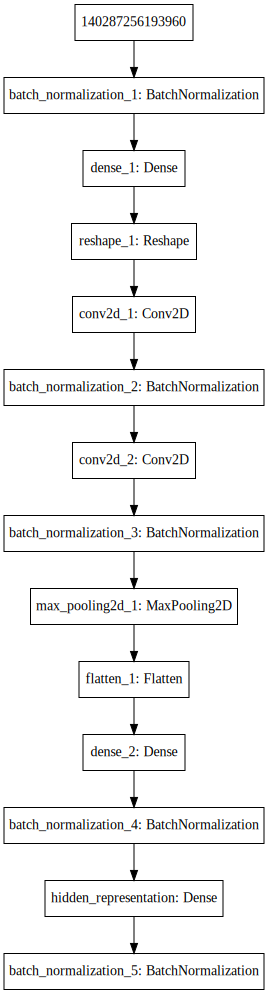

In [8]:
# Creation of the Encoder
"""
Previous encoder :
------------------
encoder = Sequential([
    BatchNormalization(input_shape=(nb_features,)),
    Dense(16 activation='tanh
    Dense(16, name="hidden_representation" ,activation='tanh'),
    ])
"""

encoder = Sequential([
    BatchNormalization(input_shape=(nb_features,)),
    Dense(2352, activation='relu'),
    Reshape((28,28,3)),
    Convolution2D(32,(3,3), activation='relu'),
    BatchNormalization(),
    Convolution2D(32,(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(16, name="hidden_representation" ,activation='tanh'),
    BatchNormalization(),
    ])

SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

In [9]:
# Anchor the input with the encoder
encoded_anchor   = encoder(input_anchor)
encoded_negative = encoder(input_negative)
encoded_positive = encoder(input_positive)

### Construction of the Triplet Network

Now we define the triplet network in charge of training the encoder declared above.

For doing that, we define two lambda layers in charge of computing the **Euclidean distances** $d(f(X), f(X⁻)) - \alpha$ and $d(f(X), f(X⁺))$ that we concatenate in a Dense layer with a **Softmax** activation on it.

Even if in the paper $\alpha$ was set to $1$, it is possible to play with this value to improve the model accuracy. In theory, bigger is $\alpha$, easier the KMeans algorithm will classify the data, but harder the Triplet Network will learn$\ldots$ Unfortunately, when setting $\alpha$ with too high values such as $20$ or $1000$, the Triplet Network explodes and outputs **NaN**. $\alpha$ is an hyperparameter that must be correctly tuned according to the data to improve the model accuracy.

The execution of the cell below also display a graphic representation of our model which is quite similar to the one presented in the paper.

In [10]:
# Creation of the model
alpha = 1.5

distance_anchor_neg = Lambda(lambda x:
                                 K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)) - alpha
                            )([encoded_anchor, encoded_negative])
distance_anchor_pos = Lambda(lambda x:
                                 K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True))
                            )([encoded_anchor, encoded_positive])

merged = concatenate([distance_anchor_neg, distance_anchor_pos], axis=-1)
output = Dense(2, activation='softmax')(merged)

model = Model(inputs=[input_anchor, input_negative, input_positive],
              outputs=output)

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Even if in the paper, the used optimizer was the **Stochastic Gradient Descent**, I have decided to use the **ADAM** optimizer.

This choice was principally motivated by the better results obtained when using **ADAM**.

*Same philosophy behind the choice of the loss function.*

In [11]:
# Configuration of the learning process
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Data loading for Triplet Network

As mentioned above, the Triplet Network has to be fed with three inputs.

#### Description of EMBER data 

>For convenience, we ensured the files labeled benign in EMBER were available in VirusTotal and at the time of collection, no vendors detected them as malicious. Likewise, we ensured that files labeled malicious in EMBER were available in VirusTotal and had more than 40 vendors report as malicious.

The EMBER data set gives us three type of data, all extracted from [VirusTotal](https://www.virustotal.com):

+ Benign : recognized as malicious by no vendors (at time of dataset creation)
+ Malicious : reported as malicious by more than 40 vendors
+ Unlabeled : no information on those one to *"encourage research in semi-supervised learning approaches [$\ldots$]  which appears to be a relatively unexplored area for malware classification in published literature"*

*I just want to highlight the fact that there are no guaranties that all the benign are still recognized as benign by all vendors today. That should have no effects in unsupervised learning, but may impact the reliability of a model trained in supervised learning.*

#### How to generate data for the Triplet Network?

The first idea that comes in my mind when generating data was to always use the unlabeled data as $X⁻$ because I was thinking that the data was unlabeled only because it was too near from being **Benign** or from being **Malicious**.

Here is a graphic representation of the data just like it was in my mind at this moment:

![](ressources/data_representation_fake.png)

Thus setting all unlabeled vectors as $X⁻$ seemed to be a good idea for me because it would allow the network to learn the exact shapes of the domain of **Benign** entities and the ones of the **Malicious** entities. In other words, the network would learn the subtleties that make a vector a **Benign** one or a **Malicious** one. It is like asking to yourself: "*What makes me human?*" instead of asking "*What makes me different from a fish?*".

Unfortunately, this idea wasn't giving the waited results$\ldots$

Then, I tried to create different types of mini-batch :
+ Benign as $X$, Malicious as $X⁻$ and Benign as $X⁺$
+ Benign as $X$, Unlabeled as $X⁻$ and Benign as $X⁺$
+ Malicious as $X$, Malicious as $X⁻$ and Malicious as $X⁺$
+ Malicious as $X$, Unlabeled as $X⁻$ and Malicious as $X⁺$

The idea behind this design was to makes the network able to learn what makes a vector **Benign** or **Malicious** and also to learn what makes a **Benign** vector different from a **Malicious** one. It is like asking to yourself: "*What makes me human?*" and "*What makes me different from a fish?*".

However, the results were not as I though$\ldots$

I came to the conclusion that neither my ideas nor my conception of the dataset were correct.

After reading the EMBER creation paper, my vision of the dataset was more like this one:

![](ressources/data_representation_real.png)

The **Unlabeled** vectors were not unlabeled because it was too hard to label them, but only to *"encourage research in semi-supervised learning approaches [$\ldots$]  which appears to be a relatively unexplored area for malware classification in published literature"*.

This is why I've aborted the idea of taking advantage of the unlabeled set.

I have decided to make the network learning only what makes a vector marked as **Benign** different from a vector marked as **Malicious**, just like simply asking to yourself: "*What makes me different from a fish?*".

And hopefully, the results were satisfactory.

In [12]:
def load_data_triplet_net(shuffle=True):
    while True:
        with open(path_train_set_benign, "r") as fd_benign,\
             open(path_train_set_malicious, "r") as fd_malicious:

            for i in range(nb_data//batch_size):
                batch_benign    = np.fromfile(fd_benign, np.float32, batch_size * nb_features)\
                                    .reshape((batch_size, nb_features))
                
                batch_malicious = np.fromfile(fd_malicious, np.float32, batch_size * nb_features)\
                                    .reshape((batch_size, nb_features))
                
                x_anchor_benign     = np.array([batch_benign[:batch_size//2],
                                                batch_malicious[:batch_size//2],
                                                batch_benign[batch_size//2:]])

                x_anchor_malicious  = np.array([batch_malicious[:batch_size//2],
                                                batch_benign[:batch_size//2],
                                                batch_malicious[batch_size//2:]])

                if (shuffle):
                    for i in range(3):
                        np.random.shuffle(x_anchor_benign[i])
                        np.random.shuffle(x_anchor_malicious[i])

                result = []
                for i in range(3):
                    l = np.concatenate((x_anchor_benign[i],
                                        x_anchor_malicious[i]), axis=0)
                    result.append(l)

                if (shuffle):
                    tmp = list(zip(result[0], result[1], result[2]))
                    np.random.shuffle(tmp)
                    result[0], result[1], result[2] = zip(*tmp)
                    result = [np.array(x) for x in result]
    
                yield (result, np.array([[1, 0]] * batch_size))

### Model training

The training is done by using the data generator declared above.
We set the number of steps per epochs and the number of epochs dependant of the number of data and the batch size so that we parse the data set one time only, however, it may improve the accuracy of the trained model if we parse the dataset more than once (*with different combinations of inputs*).

In [13]:
learn_history = model.fit_generator(load_data_triplet_net(True), steps_per_epoch=nb_data//(nb_epoch*batch_size),\
                                    epochs=nb_epoch, verbose=1)

Epoch 1/10
60/60 [==============================] - 21s 356ms/step - loss: 0.1909 - acc: 0.9798
Epoch 2/10
60/60 [==============================] - 12s 206ms/step - loss: 0.0642 - acc: 0.9960
Epoch 3/10
60/60 [==============================] - 13s 212ms/step - loss: 0.0367 - acc: 0.9987
Epoch 4/10
60/60 [==============================] - 13s 210ms/step - loss: 0.0227 - acc: 0.9995
Epoch 5/10
60/60 [==============================] - 12s 208ms/step - loss: 0.0146 - acc: 0.9996
Epoch 6/10
60/60 [==============================] - 12s 207ms/step - loss: 0.0124 - acc: 0.9998
Epoch 7/10
60/60 [==============================] - 12s 208ms/step - loss: 0.0112 - acc: 0.9999
Epoch 8/10
60/60 [==============================] - 12s 208ms/step - loss: 0.0073 - acc: 1.0000
Epoch 9/10
60/60 [==============================] - 12s 207ms/step - loss: 0.0049 - acc: 1.0000
Epoch 10/10
60/60 [==============================] - 12s 207ms/step - loss: 0.0038 - acc: 1.0000


In [14]:
def show_history(history):
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.figure(2)
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

The graphs below show that the model is correctly learning.

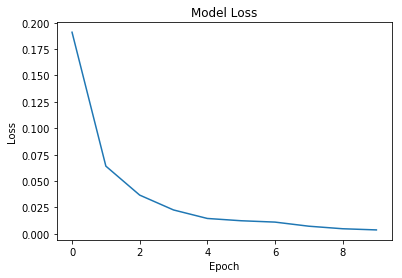

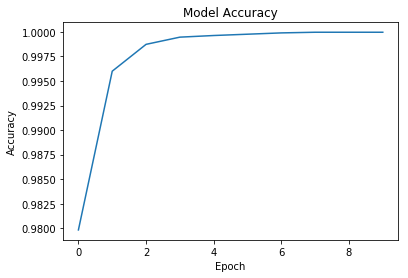

In [15]:
show_history(learn_history)

### Graphical data representation

Now that the **Triplet Network** has trained the encoder to encode vectors of data in such a way that **Benign** representations are distant from **Malicious** representations, let's visualize the data.

#### How can we visualize the learned representations?

It is possible to simply display the encoder output as a vector of floats, however, it would be hard for us to view the differences between the representation of a benign and the one of a malicious.

So to make it more visual, I preferred to display the output as a gray image of dimensions $(4\times4)$.

In [16]:
nb_img = 8

data_benign    = np.memmap(path_train_set_benign, dtype=np.float32, mode='r',
                           shape=(nb_img, nb_features))

data_malicious = np.memmap(path_train_set_malicious, dtype=np.float32, mode='r',
                           shape=(nb_img, nb_features))

data_unknown = np.memmap(path_train_set_unknown, dtype=np.float32, mode='r',
                         shape=(nb_img, nb_features))

encoded_samples = encoder.predict(np.concatenate((data_benign, data_malicious, data_unknown)))

#### Output analysis

As we can see in the figure below, the encoder seems to correctly differentiate benign vectors from malicious one.

We can even distinguish kind of families of malicious. In fact, the malicious from n°2 to n°6 seem to form a family, and the n°1 and n°7 another one.

In [17]:
fig = plt.figure(figsize=(nb_img*2, 7))

for i in range(1, nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('benign n°' + str(i-1))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')

for i in range(nb_img + 1, 2 * nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('malicious n°' + str(i - 1 - nb_img))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')
    
for i in range(2 * nb_img + 1, 3 * nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('unknown n°' + str(i - 1 - 2 * nb_img))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')

plt.show()

In [18]:
prediction = encoder.predict(test_data)
prediction.tofile(path_new_encoded)

### Results with Kmeans algorithm

If the data is now easily distinguishable with eyes, what results would we obtain with Kmeans?

In [19]:
%%bash -s "16" "$path_new_encoded"
../Kmeans/kmeans 2 100 0 $1 200000 $2 kmeans_output

Start Kmeans on dataset/Xtest_encoded.dat datafile [K = 2, dim = 16, nbVec = 200000]
Iteration: 1, Error: 4.947512
Iteration: 2, Error: 2.071392
Iteration: 3, Error: 2.051234
Iteration: 4, Error: 2.051215
Iteration: 5, Error: 2.051206
Iteration: 6, Error: 2.051205
Iteration: 7, Error: 2.051205
Iteration: 8, Error: 2.051205
Iteration: 9, Error: 2.051205
Iteration: 10, Error: 2.051205
Iteration: 11, Error: 2.051205
Iteration: 12, Error: 2.051205
Iteration: 13, Error: 2.051205
Iteration took in average 0.007839 seconds to execute 


The execution of the cell below shows us that classifying with Kmeans encoded data outperforms classifying raw data.

In fact, the accuracy of the Kmeans algorithm on raw data was only **64.24%**, while its accuracy on pre-computed data is **98,32%**. 

In [20]:
!python "./ressources/eval.py" kmeans_output dataset/Ytest.dat

shape (in     ): (200000,)
shape (correct): (200000,)
[ 1 ,  0 ,  -1 ]
Accuracy:  0.983155
Precision:  0.9832168112099444
Recall:  0.983155
Confusion Matrix:  [[98881  1119]
 [ 2250 97750]]


### Results with another type of classifier

It wasn't asked in the assignment, however, I found that it would be interesting to compare if the learned representations would still be exploitable with another classifier than the one for which the data has been encoded.

I mean by that that the goal of the Triplet Network was to learn such representations that the Euclidean distance between malicious and benign would be big enough to improve the results obtained by our Kmeans algorithm that is also based on Euclidean distances between vectors.

The model used is really simple, it is just a dense layer of two neurons with a **Softmax** on it.

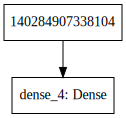

In [21]:
classifier = Sequential()
classifier.add(Dense(2, input_dim=16, activation='softmax'))

SVG(model_to_dot(classifier).create(prog='dot', format='svg'))

In [22]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Unlike the Kmeans algorithm, this model needs to know the correct answers.

This is the purpose of the function below, generating random encoded vectors associated with their correct labels.

In [23]:
def load_data_special_classifier(shuffle=True):
    while True:
        with open(path_train_set_benign, "r") as fd_benign,\
             open(path_train_set_malicious, "r") as fd_malicious:

            for i in range(nb_data//batch_size):
                x_benign    = np.fromfile(fd_benign, np.float32, batch_size * nb_features)\
                                .reshape((batch_size, nb_features))

                x_malicious = np.fromfile(fd_malicious, np.float32, batch_size * nb_features)\
                                .reshape((batch_size, nb_features))

                y_benign    = [[1, 0]] * batch_size
                y_malicious = [[0, 1]] * batch_size
                
                x = np.concatenate((x_benign, x_malicious))
                x = encoder.predict(x)
                y = np.concatenate((y_benign, y_malicious))
                
                if (shuffle):
                    tmp = list(zip(x, y))
                    np.random.shuffle(tmp)
                    x, y = zip(*tmp)
                    
                yield (np.array(x), np.array(y))

In [24]:
learn_history = classifier.fit_generator(load_data_special_classifier(), steps_per_epoch=nb_data//(nb_epoch*batch_size),\
                                         epochs=nb_epoch, verbose=1)

Epoch 1/10
60/60 [==============================] - 11s 179ms/step - loss: 0.1535 - acc: 0.9487
Epoch 2/10
60/60 [==============================] - 11s 181ms/step - loss: 0.0826 - acc: 0.9737
Epoch 3/10
60/60 [==============================] - 11s 181ms/step - loss: 0.0662 - acc: 0.9781
Epoch 4/10
60/60 [==============================] - 11s 179ms/step - loss: 0.0601 - acc: 0.9796
Epoch 5/10
60/60 [==============================] - 11s 179ms/step - loss: 0.0427 - acc: 0.9856
Epoch 6/10
60/60 [==============================] - 11s 179ms/step - loss: 0.0594 - acc: 0.9778
Epoch 7/10
60/60 [==============================] - 11s 191ms/step - loss: 0.0839 - acc: 0.9717
Epoch 8/10
60/60 [==============================] - 11s 185ms/step - loss: 0.0664 - acc: 0.9770
Epoch 9/10
60/60 [==============================] - 11s 186ms/step - loss: 0.0349 - acc: 0.9881
Epoch 10/10
60/60 [==============================] - 11s 181ms/step - loss: 0.0276 - acc: 0.9910


*The encountered peak at the 6$^{th}$ epoch is explained by the fact that the generator load the data sequentially and then randomize them, instead of directly load them randomly. The reason of this local randomness is that I'm working on a slow HDD, and it would take an hour to train this model with random disk read on my machine$\ldots$*

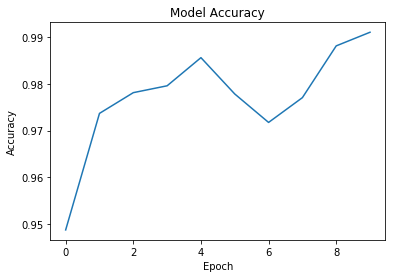

In [25]:
show_history(learn_history)

In [26]:
y_test = np.memmap("dataset/Ytest.dat", dtype=np.float32, mode='r')
y_test = utils.to_categorical(y_test, 2)

Finally, we almost obtained the same result than with the Kmeans algorithm.

In [27]:
classifier.evaluate(prediction, y_test)

200000/200000 [==============================] - 8s 40us/step


[0.054928817671630534, 0.98236]

## Supervised learning with Convolutional Neural Network

### Why a Convolutional Neural Network?

At the beginning, to make the data a bit more visual than vector of floats, I have decided to normalize some vectors of the dataset with **keras.utils.normalize** function and then reshape them with the shapes of a colored 2-dimensional image to finally display them with **matplotlib**.

I then realized that by adding one to the dimension of the **EMBER**'s vectors, we reached 2352.
And the cool thing with "2352" is that: $2352 = 784 \times 3 = 28 \times 28 \times 3$.

It turns out that the **MNIST** dataset (*I know it from the OCR project of the S3*) proposes images of dimensions $28 \times 28 \times 1$. So without reflections, I've chosen to steal the architecture of a model that had really a good accuracy on this dataset, and to simply adapt it to the classification of **EMBER**'s vectors.

### Model description

The model still starts with a **BatchNormalization** layer for the same reasons explained above. We then add a dense layer that outputs 2352 features from the 2351 that it receives (*this trick gives better results and is more efficient than padding with a zero the input vector*), we then reshape it and feed the convolutional neural network.

The penultimate dense layer of **16** neurons does not improve the results, but is useful to view the data representation learned by the network.

In [28]:
classifier = Sequential([
    BatchNormalization(input_shape=(nb_features,)),
    Dense(2352, activation='relu'),
    Reshape((28,28,3)),
    Convolution2D(32,(3,3), activation='relu'),
    Convolution2D(32,(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(16, name="hidden_representation" ,activation='tanh'),
    Dense(2, activation='softmax')
    ])

SVG(model_to_dot(classifier).create(prog='dot', format='svg'))

### Data loading

The loading of the data is achieved with the almost same function than for the classifier above.
The only difference is that the input data is raw.

Below there are two kinds of data loader:

+ A sequential reader with local randomness (*faster*)
+ A random access reader with global randomness (*slightly better*)

They both give similar results even though the random one is more stable.

In [29]:
def load_data_classifier(shuffle=True):
    while True:
        with open(path_train_set_benign, "r") as fd_benign,\
             open(path_train_set_malicious, "r") as fd_malicious:

            for i in range(nb_data//batch_size):
                x_benign    = np.fromfile(fd_benign, np.float32, batch_size * nb_features)\
                                .reshape((batch_size, nb_features))

                x_malicious = np.fromfile(fd_malicious, np.float32, batch_size * nb_features)\
                                .reshape((batch_size, nb_features))

                y_benign    = [[1, 0]] * batch_size
                y_malicious = [[0, 1]] * batch_size
                
                x = np.concatenate((x_benign, x_malicious))                
                y = np.concatenate((y_benign, y_malicious))
                
                if (shuffle):
                    tmp = list(zip(x, y))
                    np.random.shuffle(tmp)
                    x, y = zip(*tmp)
                    
                yield (np.array(x), np.array(y))

In [30]:
def load_data_classifier_rnd_read():

    x_benign    = np.memmap(path_train_set_benign, dtype=np.float32, mode='r',\
                           shape=(nb_data, nb_features))
    
    x_malicious = np.memmap(path_train_set_malicious, dtype=np.float32, mode='r',\
                               shape=(nb_data, nb_features))
    
    indices = np.arange(0, nb_data, dtype=int)
    np.random.shuffle(indices)
    
    while True:
        for i in range(nb_data//batch_size):
            x, y = [None] * 2 * batch_size, [None] * 2 * batch_size
            
            for j in range(batch_size):
                x[j] = x_benign[indices[i * batch_size + j]]
                y[j] = [1, 0]
                
            for j in range(batch_size):
                x[batch_size + j] = x_malicious[indices[i * batch_size + j]]
                y[batch_size + j] = [0, 1]
                
            tmp = list(zip(x, y))
            np.random.shuffle(tmp)
            x, y = zip(*tmp)
            
            yield (np.array(x), np.array(y))

In [31]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model training

In [32]:
learn_history = classifier.fit_generator(load_data_classifier_rnd_read(), steps_per_epoch=nb_data//(nb_epoch*batch_size),\
                                    epochs=nb_epoch, verbose=1)

Epoch 1/10
60/60 [==============================] - 305s 5s/step - loss: 0.2806 - acc: 0.8886
Epoch 2/10
60/60 [==============================] - 162s 3s/step - loss: 0.0702 - acc: 0.9770
Epoch 3/10
60/60 [==============================] - 151s 3s/step - loss: 0.0615 - acc: 0.9796
Epoch 4/10
60/60 [==============================] - 161s 3s/step - loss: 0.0565 - acc: 0.9818
Epoch 5/10
60/60 [==============================] - 166s 3s/step - loss: 0.0516 - acc: 0.9825
Epoch 6/10
60/60 [==============================] - 213s 4s/step - loss: 0.0477 - acc: 0.9841
Epoch 7/10
60/60 [==============================] - 231s 4s/step - loss: 0.0458 - acc: 0.9848
Epoch 8/10
60/60 [==============================] - 255s 4s/step - loss: 0.0432 - acc: 0.9856
Epoch 9/10
60/60 [==============================] - 333s 6s/step - loss: 0.0407 - acc: 0.9864
Epoch 10/10
60/60 [==============================] - 324s 5s/step - loss: 0.0373 - acc: 0.9874


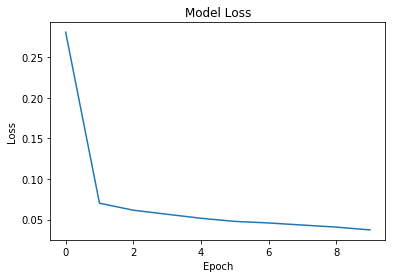

In [33]:
show_history(learn_history)

### Model accuracy on the test set

This model, with its accuracy of **98,69%**, is softly more accurate than the previous classifiers.

In [34]:
classifier.evaluate(test_data, y_test)

200000/200000 [==============================] - 33s 163us/step


[0.038517786390502004, 0.986885]

### Graphical data representation

I found that it may be interesting to compare the representations learned by the **Triplet Network**, which goal was to distantiate elements of different classes with the representation learned by this classifier which goal was to correctly classify raw data.

#### How to?

To do such a thing, we create an intermediate model for which the input stays the same than the trained classifier and the output is the internal layer of 16 neurons. Thus we get the internal representation of the classifier.

#### Output anlaysis

Just like with the **Triplet Network**, we can differentiate benign representations from malicious one and even distinguish families in both camps.

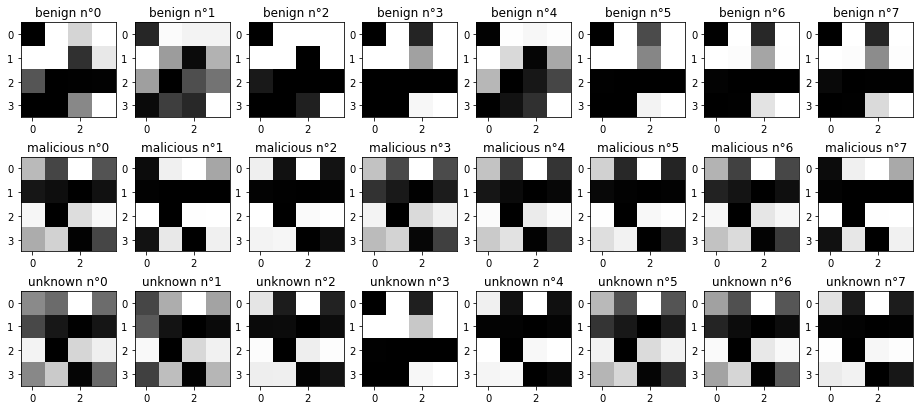

In [35]:
intermediate = Model(inputs=classifier.input,
                     outputs=classifier.get_layer("hidden_representation").output)
encoded_samples = intermediate.predict(np.concatenate((data_benign, data_malicious, data_unknown)))

fig = plt.figure(figsize=(nb_img*2, 7))

for i in range(1, nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('benign n°' + str(i-1))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')

for i in range(nb_img + 1, 2 * nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('malicious n°' + str(i - 1 - nb_img))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')
    
for i in range(2 * nb_img + 1, 3 * nb_img + 1):
    fig.add_subplot(3, nb_img, i)
    plt.title('unknown n°' + str(i - 1 - 2 * nb_img))
    plt.imshow(encoded_samples[i - 1].reshape(4,4), cmap='gray', interpolation='nearest')

plt.show()

### Results with Kmeans algorithm

We have seen that the representations learned by the **Triplet Network** are exploitable by other classifiers than the one for which they have been designed.

#### Is it still the case?

The images above give a hint$\ldots$
Let's encode the raw data with the extracted intermediate layer and save the representations in a file.

In [36]:
prediction = intermediate.predict(test_data)
prediction.tofile(path_new_encoded)

Then we feed the Kmeans classifier with this file.

In [37]:
%%bash -s "16" "$path_new_encoded"
../Kmeans/kmeans 2 100 0 $1 200000 $2 kmeans_output

Start Kmeans on dataset/Xtest_encoded.dat datafile [K = 2, dim = 16, nbVec = 200000]
Iteration: 1, Error: 3.336532
Iteration: 2, Error: 0.858304
Iteration: 3, Error: 0.846317
Iteration: 4, Error: 0.845549
Iteration: 5, Error: 0.845500
Iteration: 6, Error: 0.845500
Iteration: 7, Error: 0.845500
Iteration: 8, Error: 0.845500
Iteration: 9, Error: 0.845500
Iteration: 10, Error: 0.845500
Iteration: 11, Error: 0.845500
Iteration: 12, Error: 0.845500
Iteration: 13, Error: 0.845500
Iteration: 14, Error: 0.845500
Iteration: 15, Error: 0.845500
Iteration: 16, Error: 0.845500
Iteration: 17, Error: 0.845500
Iteration: 18, Error: 0.845500
Iteration: 19, Error: 0.845500
Iteration: 20, Error: 0.845500
Iteration: 21, Error: 0.845500
Iteration: 22, Error: 0.845500
Iteration: 23, Error: 0.845500
Iteration: 24, Error: 0.845500
Iteration: 25, Error: 0.845500
Iteration took in average 0.008161 seconds to execute 


And as we can see below, the internal representation of the classifier is exploitable by another type of classifier.

Such as the **Triplet Network**, the **Convolutionnal Neural Network** classifier internally learned to distantiate inputs of different classes.

In [38]:
!python "./ressources/eval.py" kmeans_output dataset/Ytest.dat

shape (in     ): (200000,)
shape (correct): (200000,)
[ 1 ,  0 ,  -1 ]
Accuracy:  0.986685
Precision:  0.9867503842542911
Recall:  0.986685
Confusion Matrix:  [[99248   752]
 [ 1911 98089]]


In [39]:
K.clear_session()

## Conclusion

The different methods of classification of the **EMBER** dataset that we have tested above nearly lead us to the same results ($\approx98$%).

However, if I had to make a choice between one of them, I would argue that I prefer the **Triplet Network** combined with the Kmeans classifier.

Even if the results obtained with the **Triplet Network** are slightly less accurate, we have the guarantee that the model is not corrupted by some labeling error made during the creation of the **EMBER** dataset.

In fact, we can't be sure that a program labeled as benign today will still be tomorrow.
Fortunately, a low amount of labeling errors should not greatly impact the **Convolutional Neural Network** classifier.

### Limitations

I did not take advantage of the unlabeled set. I think that a better investigation on it would lead in a better accuracy of the Triplet Network model.

### Issues

It seems that I have made an error during the **Triplet Network** modeling$\ldots$
Even with the $\alpha$, the network is still able to learn the function $f$ that match the condition : $\exists Y, \forall X, f(X) = Y$.

Moreover, if we do not set the seed to 0 with :

    np.random.seed(0)
    tf.set_random_seed(0)

The **Triplet Network** outputs really different results, and most of the time, they are below an accuracy of **70%**.

I don't understand the error that I have made, and why it works sometimes and sometimes not.